# Training and evaluation

1. Caricamento dei dati di training, validazione e test preparati in precedenza
2. Definizione di una funzione per calcolare le metriche di valutazione (RMSE, MAE, R^2)
3. Addestramento e valutazione di un modello di baseline (Ridge Regression)
4. Addestramento e valutazione di modelli più complessi (RandomForestRegressor, XGBRegressor)
5. Confronto finale delle performance

In [19]:
RANDOM_STATE = 42

### Caricamento splittings

In [20]:
import pandas as pd
import os

X_train = pd.read_csv(os.getcwd()+'/processed_data/X_train.csv')
X_val = pd.read_csv(os.getcwd()+'/processed_data/X_val.csv')
X_test = pd.read_csv(os.getcwd()+'/processed_data/X_test.csv')

y_train = pd.read_csv(os.getcwd()+'/processed_data/y_train.csv').values.ravel()
y_val = pd.read_csv(os.getcwd()+'/processed_data/y_val.csv').values.ravel()
y_test = pd.read_csv(os.getcwd()+'/processed_data/y_test.csv').values.ravel()

In [21]:
print(f"Training set:   X_train -> {X_train.shape}, y_train -> {y_train.shape}")
print(f"Validation set: X_val   -> {X_val.shape}, y_val   -> {y_val.shape}")
print(f"Test set:       X_test  -> {X_test.shape}, y_test  -> {y_test.shape}")

Training set:   X_train -> (5983, 107), y_train -> (5983,)
Validation set: X_val   -> (1283, 107), y_val   -> (1283,)
Test set:       X_test  -> (1283, 107), y_test  -> (1283,)


### Funzione di Valutazione

Serve per mantenere il codice pulito e a valutare ogni modello in modo consistente.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(y_true, y_pred, model_name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- Results for {model_name} ---")
    print(f"RMSE:\t\t{rmse:.4f}")
    print(f"MAE:\t\t{mae:.4f}")
    print(f"R-squared:\t{r2:.4f}")
    print("-" * 30)

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}


Per ottimizzare gli iperparametri ho scelto l’RMSE come metrica principale di validazione. Ho fatto questa scelta perché l’RMSE penalizza di più gli errori grandi, spingendo così il modello a evitare previsioni molto lontane dai valori reali. Ho comunque considerato anche MAE e R^2 per avere una visione più completa delle prestazioni.

### Baseline: Ridge Regression (tuning and evaluation)

In [23]:
from sklearn.linear_model import Ridge
import numpy as np

# griglia degli iperparametri da utilizzare (dizionario)
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

best_rmse = float('inf')
best_alpha = None
best_ridge_model = None

# grid search implementata manualmente
for alpha in param_grid_ridge['alpha']:
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)  # altri parametri di default
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    current_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    print(f"alpha: {alpha} -> RMSE: {current_rmse:.4f}")

    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_alpha = alpha
        best_ridge_model = model

print(f"best_alpha: {best_alpha}")
print(f"best_rmse: {best_rmse:.4f}")


alpha: 0.01 -> RMSE: 1.0846
alpha: 0.1 -> RMSE: 1.0844
alpha: 1.0 -> RMSE: 1.0836
alpha: 10.0 -> RMSE: 1.0829
alpha: 100.0 -> RMSE: 1.0849
best_alpha: 10.0
best_rmse: 1.0829


evaluation del best models sul test set, calcolando tutte le metriche:

In [24]:
y_test_pred_ridge = best_ridge_model.predict(X_test)
ridge_test_metrics = evaluate_model(y_test, y_test_pred_ridge, f"Ridge")

--- Results for Ridge ---
RMSE:		1.1785
MAE:		0.8150
R-squared:	0.1761
------------------------------


salviamo i risultati per il confronto finale

In [25]:
results = {}
results[f'Ridge'] = ridge_test_metrics
results

{'Ridge': {'RMSE': np.float64(1.1785198487367596),
  'MAE': 0.814963320265847,
  'R2': 0.17607789366164772}}

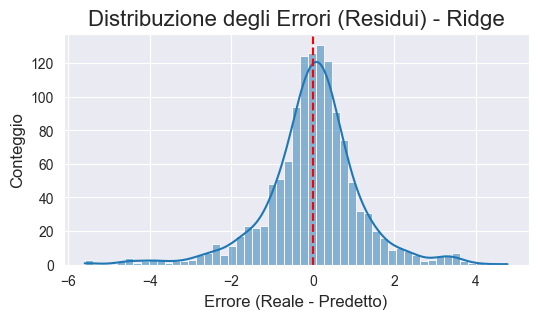

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

residui_ridge = y_test - y_test_pred_ridge

plt.figure(figsize=(6, 3))
sns.histplot(residui_ridge, kde=True)

# Aggiungiamo una linea di riferimento a x=0 (errore nullo)
plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribuzione degli Errori (Residui) - Ridge', fontsize=16)
plt.xlabel('Errore (Reale - Predetto)', fontsize=12)
plt.ylabel('Conteggio', fontsize=12)
plt.show()


osservazioni:
- distribuzione approssimativamente normale
- media molto vicina allo zero: il modello non tende nè a sovrastimare nè a sottostimare
- la maggioranza degli errori si concentra nel range [-2, 2], coerente con l'RMSE di 1.18

Analizziamo le feature più influenti per il modello

In [27]:
coefficients = best_ridge_model.coef_
feature_names = X_train.columns
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

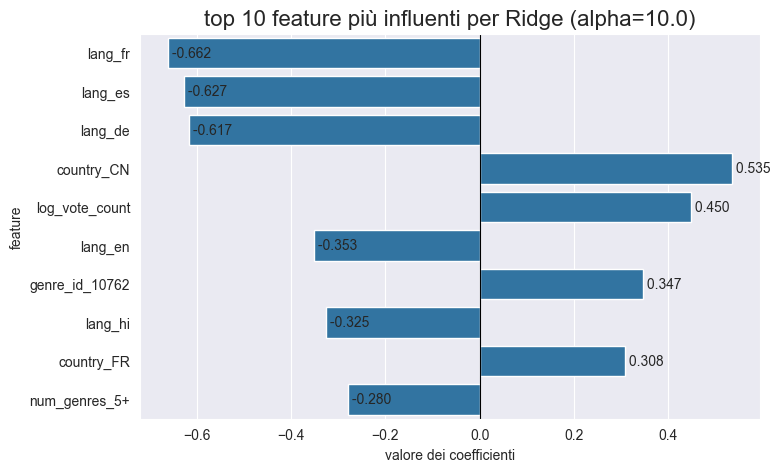

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='coefficient', y='feature', data=coef_df.head(10))
plt.title(f'top 10 feature più influenti per Ridge (alpha={best_alpha})', fontsize=16)
plt.xlabel('valore dei coefficienti')
plt.ylabel('feature')
plt.axvline(0, color='black', linewidth=0.8)

# per inserire il valore nella barra
for index, value in enumerate(coef_df.head(10)['coefficient']):
    plt.text(value, index, f' {value:.3f}', va='center')

plt.show()


osservazioni:
- Le tre feature più influenti in assoluto sono "lang_fr", "lang_es" e "lang_de". Questo risultato è in linea con l'analisi esplorativa, dove avevamo osservato che le serie in lingua francese, spagnola e tedesca avevano un voto medio più basso rispetto alle altre.
- il modello ha imparato ad associare un numero molto elevato di generi a una valutazione leggermente più bassa
- La feature più influente in senso positivo è country_CN, quindi le produzioni cinesi tendono ad avere un voto medio maggiore
- log_vote_count (+0.450) è il secondo predittore positivo più forte, confermando l'analisi preliminare e l'efficacia della trasformazione logaritmica
- genre_id_10762 (+0.347) ha un impatto positivo (genere kids)
- country_FR (+0.308) ha un coefficiente positivo, il che va in contrasto con l'analisi sulla lingua: evidentemente secondo il modello le co-produzioni che includono la Francia ma che non sono necessariamente in lingua francese tendono ad avere un voto maggiore

### RandomForestRegressor

Passiamo ora a un modello più potente, il RandomForestRegressor. Essendo un modello basato su alberi, può catturare relazioni non lineari che la RidgeRegression non riesce a modellare.

Per trovare la migliore combinazione di iperparametri, utilizzeremo GridSearchCV (di scikit-learn). Esso verrà addestrato usando il nostro training set e valutato su ogni combinazione usando il nostro validation set. Questo si ottiene passando uno "splitter" personalizzato (PredifinedSplit) a GridSearchCV.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# per utilizzare i nostri split
X_train_val = pd.concat([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
# array per dire quali indici inserire nel test (-1 per quelli da inserire nel training)
split_index = [-1] * len(X_train) + [0] * len(X_val)
ps = PredefinedSplit(test_fold=split_index)


param_grid_rf = {
    'n_estimators': [100, 150, 200],         # numero di alberi nell'ensemble
    'max_depth': [10, 20, 30, None],        # profondità massima che può avere un albero
    'min_samples_leaf': [2, 3, 4],         # campioni (osservazioni) minimi che devono trovarsi in un nodo "foglia"
                                        # SERVE PER BLOCCARE LA CREASCITA DELL'ALBERO
    'max_features': ['sqrt', 'log2']    # verranno considerate sqrt(n_features) feature o log2(n_features) feature
}

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1) # utilizziamo tutti i processori

grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid_rf,
                              cv=ps,  # nostro split personalizzato
                              scoring='neg_root_mean_squared_error', # metrica di scoring
                              verbose=2,  # Mostra i progressi
                              n_jobs=-1) # Usa tutti i core della CPU

grid_search_rf.fit(X_train_val, y_train_val)
print("tuning completed")

Fitting 1 folds for each of 72 candidates, totalling 72 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=150; total time=   1.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, n_estimators=150; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_sa

In [30]:
print(f"Best params: {grid_search_rf.best_params_}")
best_validation_rmse_rf = -grid_search_rf.best_score_
print(f"Best RMSE: {best_validation_rmse_rf:.4f}")
best_rf_model = grid_search_rf.best_estimator_

Best params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
Best RMSE: 1.0381


Ora che abbiamo trovato il modello ottimale, lo valutiamo sul test set e analizziamo l'importanza delle feature.

In [31]:
y_test_pred_rf = best_rf_model.predict(X_test)
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, "RandomForest (tuned)")
results['RandomForest'] = rf_test_metrics

--- Results for RandomForest (tuned) ---
RMSE:		1.1407
MAE:		0.7771
R-squared:	0.2281
------------------------------


Analizziamo l'importanza delle feature

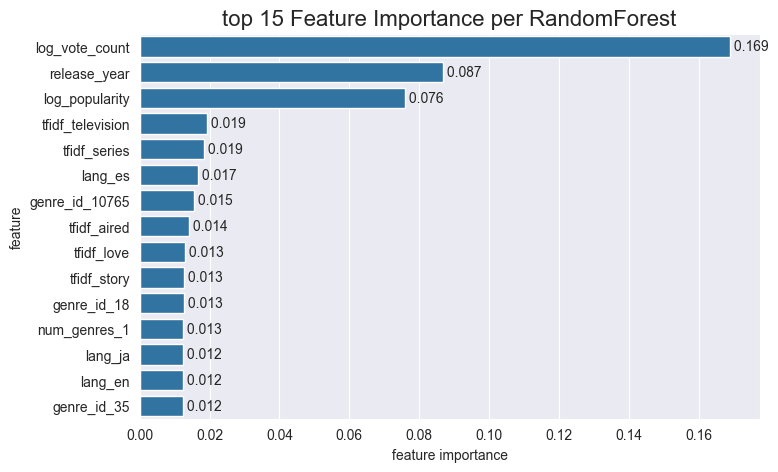

In [32]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('top 15 Feature Importance per RandomForest', fontsize=16)
plt.xlabel('feature importance')
plt.ylabel('feature')

# per inserire il valore nella barra
for index, value in enumerate(importance_df.head(15)['importance']):
    plt.text(value, index, f' {value:.3f}', va='center')

plt.show()


osservazioni:
- Le tre feature più importanti in assoluto, e con un distacco notevole, sono log_vote_count (0.169), release_year (0.087) e log_popularity (0.076). La loro importanza combinata è quasi il 1/3 del potere predittivo totale del modello.
- al contrario della Ridge Regression, diverse feature derivate dal testo (overview) si posizionano in alto nella, in particolare tfidf_television (0.019) e tfidf_series (0.019) ma anche le altre, quindi l'approccio di NLP ha avuto successo in questo caso
- anche se in forma diversa, conferma che la lingua è un fattore discriminante
- anche i risultati sui generi, validano il nostro preprocessing
- anche qui importanza assoluta di log_vote_count
- c'è importanza per le feature numeriche relase_year e log_popularity che manca nel Ridge Regression, verificando l'ipotesi per cui ci fosse una relazione non lineare tra queste feature e il vote_average; la natura del RandomForestRegressor gli permette di catturare queste relazioni complesse

è importantissimoi sottolineare la differenza di questi due approcci:
1. Ridge ci dice la "direzione" dell'effetto di una feature, ovverò ci dice se la feature in questione ha un effetto importante o meno sia in senso negativo sia in senso positivo
2. RandomForestRegressor ci dà solo l'importanza generale a livello di split, cioè quanto una feature è presente nelle regole interne degli alberi del modello

Per capire meglio la logica interna del Random Forest, possiamo estrarre e visualizzare uno dei singoli alberi decisionali che compongono l'ensemble. Questo ci mostra (primo albero regressore del modello) un esempio delle regole di split che il modello ha imparato dai dati.

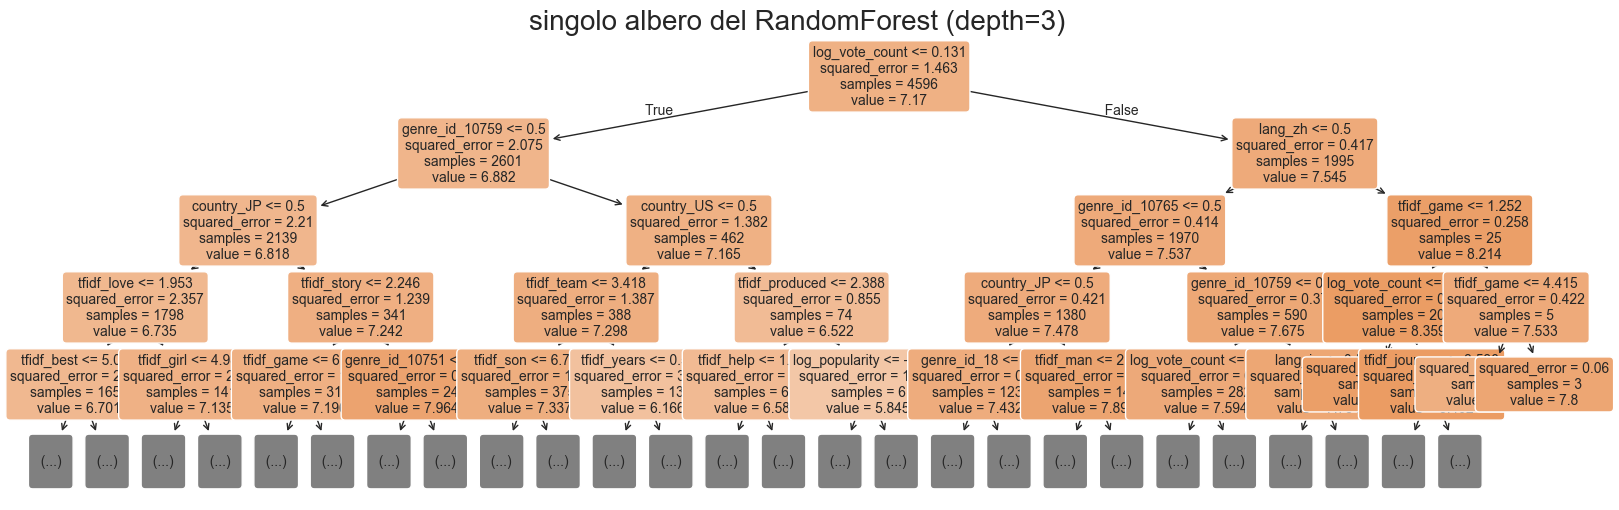

In [33]:
single_tree = best_rf_model.estimators_[0]

from sklearn.tree import plot_tree
plt.figure(figsize=(20,6))
plot_tree(single_tree,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          max_depth=4, # profondità limitata a 3 livelli per semplicità di visualizzazione
          fontsize=10)
plt.title('singolo albero del RandomForest (depth=3)', fontsize=20)
plt.show()

osservazioni:
- Il modello non considera tutte le feature contemporaneamente e impara una gerarchia di decisioni
- utilizza attivamente tutti i tipi di feature che abbiamo creato

N.B. Questa è la logica di un solo albero poichè l'appropccio RandomForest combina le previsioni di numerosi alberi costruiti in modo simile, ognuno addestrato su un sottoinsieme leggermente diverso dei dati e delle feature. La previsione finale è la media di tutte queste previsioni individuali, rendendo il modello complessivo più stabile e accurato di un singolo albero.


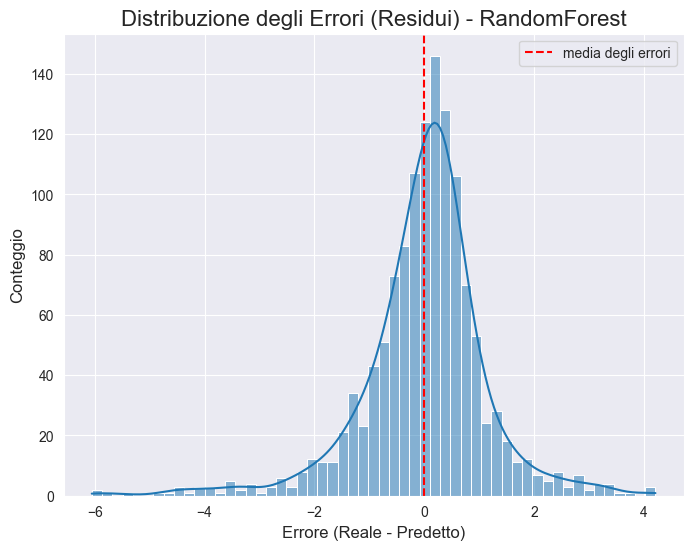

--- Statistiche sui Residui del RandomForest ---
Media dei residui: -0.0025
Deviazione standard dei residui: 1.1407


In [34]:
residui_rf = y_test - y_test_pred_rf

plt.figure(figsize=(8, 6))
sns.histplot(residui_rf, kde=True)
plt.axvline(x=np.mean(residui_rf), color='red', linestyle='--', label='media degli errori')
plt.title('Distribuzione degli Errori (Residui) - RandomForest', fontsize=16)
plt.xlabel('Errore (Reale - Predetto)', fontsize=12)
plt.ylabel('Conteggio', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# (Opzionale) Possiamo anche stampare alcune statistiche sui residui
print("--- Statistiche sui Residui del RandomForest ---")
print(f"Media dei residui: {np.mean(residui_rf):.4f}")
print(f"Deviazione standard dei residui: {np.std(residui_rf):.4f}")


osservazioni:
- distribuzione approssimativamente normale
- media molto vicina allo zero: il modello non tende nè a sovrastimare nè a sottostimare
- la maggioranza degli errori si concentra nel range [-2, 2], coerente con l'RMSE di 1.14


In [35]:
residui_df = pd.DataFrame({
    'Ridge': residui_ridge,
    'RandomForest': residui_rf
})
residui_stats = residui_df.describe()
residui_stats

,Ridge,RandomForest
count,1283.000000,1283.000000
mean,0.000447,-0.002496
std,1.178979,1.141133
min,-5.597819,-6.052659
25%,-0.494116,-0.472686
50%,0.049463,0.101740
75%,0.571196,0.544826
max,4.774505,4.206158


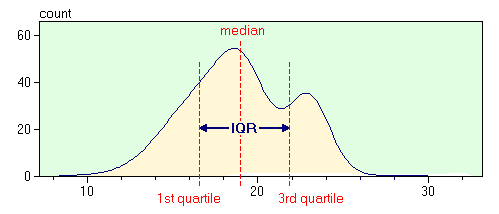

In [36]:
iqr_ridge = residui_stats.loc['75%', 'Ridge'] - residui_stats.loc['25%', 'Ridge']
iqr_rf = residui_stats.loc['75%', 'RandomForest'] - residui_stats.loc['25%', 'RandomForest']
print(f"IQR per Ridge:          {iqr_ridge}")
print(f"IQR per RandomForest:   {iqr_rf}")

IQR per Ridge:          1.0653122940834896
IQR per RandomForest:   1.0175114090928172


- media praticamente uguale e nulla, nessuno dei due modelli ha un bias sistematico
- std inferiore per il RandomForest, quindi ha meno dispersione degli errori
- IQR più stretto per RandomForest, quindi più prevedibile e consistente

### Support Vector Regression (SVR)

Come secondo approccio non basato su alberi, valuto un modello Support Vector Regression (SVR). Questo modello è metodologicamente molto diverso dai precedenti, poiché utilizza la "kernel trick" per mappare le feature in uno spazio a dimensionalità superiore, dove può catturare relazioni non lineari complesse.

In [37]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


param_grid_svr = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1.0, 10.0, 100.0], # Parametro di regolarizzazione
    'gamma': ['scale', 0.1], # Coefficiente del kernel RBF
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR()

grid_search_svr = GridSearchCV(estimator=svr,
                               param_grid=param_grid_svr,
                               cv=ps, # Riusiamo lo split train/validation predefinito
                               scoring='neg_root_mean_squared_error',
                               verbose=2,
                               n_jobs=-1)

grid_search_svr.fit(X_train_val, y_train_val)


print(f"\nbest params: {grid_search_svr.best_params_}")
best_validation_rmse_svr = -grid_search_svr.best_score_
print(f"best RMSE: {best_validation_rmse_svr:.4f}")
best_svr_model = grid_search_svr.best_estimator_

Fitting 1 folds for each of 48 candidates, totalling 48 fits
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   5.8s
[CV] END ..........C=0.1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   5.9s
[CV] END .........C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   6.1s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   6.3s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=   6.3s
[CV] END .......C=0.1, epsilon=0.1, gamma=0.1, kernel=linear; total time=   6.3s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.1, kernel=linear; total time=   7.2s
[CV] END ........C=0.1, epsilon=0.5, gamma=scale, kernel=rbf; total time=   3.3s
[CV] END .....C=0.1, epsilon=0.5, gamma=scale, kernel=linear; total time=   3.4s
[CV] END ..........C=0.1, epsilon=0.5, gamma=0.1, kernel=rbf; total time=   3.4s
[CV] END .......C=0.1, epsilon=0.5, gamma=0.1, k

In [38]:
y_test_pred_svr = best_svr_model.predict(X_test)
svr_test_metrics = evaluate_model(y_test, y_test_pred_svr, "SVR")
results['SVR'] = svr_test_metrics

--- Results for SVR ---
RMSE:		1.1840
MAE:		0.8075
R-squared:	0.1684
------------------------------


tecnica di Permutation Feature Importance: https://christophm.github.io/interpretable-ml-book/feature-importance.html
- Si calcola il punteggio del modello (es. RMSE) sul set di validazione. Questo rappresenta il nostro punteggio di baseline. Otteniamo l'errore del modello quado esso lavora normalmente. (già fatto precedentemente)
- Si prende il validation set e si seleziona una feature per volta. Si mescolano casualmente tutti i valori all'interno di quella feature. In questo modo, non c'è più relazione tra feature e target. La feature diventa rumore casuale.
- Si riutilizza il modello senza ri-addestrarlo per fare previsioni sul set di dati modificato. Si ricalcola RMSE che ci dà le performance dopo la permutazione.
- L'importanza della feature è data dalla differenza tra l'errore dopo e prima della performance. Solitamente, il procedimento viene ripetuto più volte per avere un risultato più stabile e veritiero.
    - Se l'importanza è un numero grande e positivo, significa che l'errore è aumentato molto dopo la permutazione. Quindi la feature era importante per il modello.
    - Se l'importanza è vicina a zero, significa che l'errore non è cambiato quasi per niente. Quindi la feature era irrilevante.
- Questo procedimento viene effettuato per ogni feature del dataset.


Ho scelto questa tecnica perchè agnostica rispetto al modello. Per SVR non potevamo seguire lo stesso approccio utilizzato per i precedenti modelli.

In [39]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_svr_model,
    X_val,
    y_val,
    n_repeats=10,  # ripetizioni per avere un risultato stabile e sicuro
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="neg_mean_squared_error"  # scorer
)



In [40]:
# 'result.importances_mean' indica l'aumento medio di MSE, quindi un valore positivo
importance_increase_in_mse = result.importances_mean
perm_importance_df_mse = pd.DataFrame({
    'feature': X_val.columns,
    'importance_increase': importance_increase_in_mse
})
perm_importance_df_mse = perm_importance_df_mse.sort_values('importance_increase', ascending=False)
perm_importance_df_mse

,feature,importance_increase
36,log_vote_count,0.399480
26,lang_en,0.040848
30,lang_es,0.024687
17,country_JP,0.023391
31,lang_de,0.013191
...,...,...
100,tfidf_war,-0.000759
101,tfidf_way,-0.000769
41,tfidf_based,-0.000823
95,tfidf_team,-0.000865


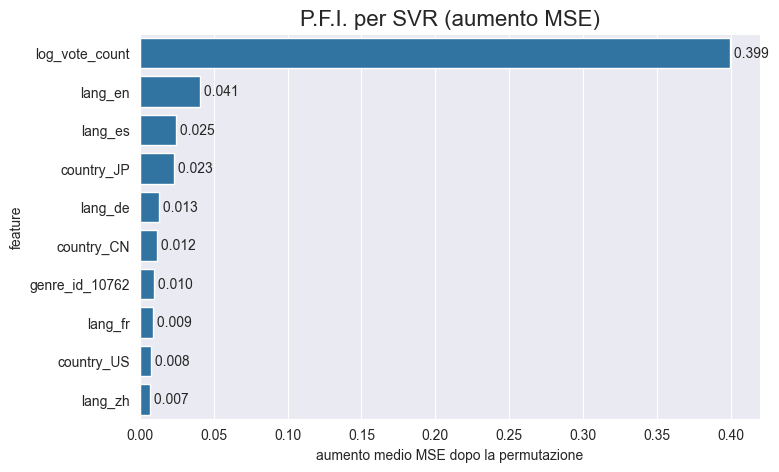

In [41]:
plt.figure(figsize=(8, 5))
sns.barplot(x='importance_increase',
            y='feature',
            data=perm_importance_df_mse.head(10))

plt.title('P.F.I. per SVR (aumento MSE)', fontsize=16)
plt.xlabel('aumento medio MSE dopo la permutazione')
plt.ylabel('feature')

for index, value in enumerate(perm_importance_df_mse.head(10)['importance_increase']):
    plt.text(value, index, f' {value:.3f}', va='center')

plt.show()

osservazioni:
- La feature log_vote_count è di gran lunga la più importante, con un aumento medio dell'MSE di 0.399. Questo è un valore enormemente superiore a tutte le altre feature, anche rispetto alla seconda ("country_JP"). Questo conferma che log_vote_count è il predittore più forte che abbiamo a disposizione.
- Le feature successive più importanti sono tutte legate alla provenienza geografica o linguistica del programma TV.
- Qui lang_en emerge come la terza feature più importante. La P.F.I. non ci dice la direzione dell'effetto, ma ci dice che sapere se uno show è in inglese è molto utile per SVR, a differenza dei modelli lineari.
- A differenza del RandomForest, nessuna delle feature TF-IDF compare nella top 10. Forse perchè sono feature molto sparse e influiscono negativamente sul concetto di distanza e di dimensionalità di SVR.
- Sia la feature country_JP che lang_ja appaiono nella top 4 (rispettivamente seconda e quarta), anche se altamente correlate. Questo rafforza le altre analisi per cui questi due tipi di feature portino a informazioni complementari.
- Il RandomForest riteneva queste due feature la seconda e la terza più importanti. L'SVR, invece, non le include nella sua top 10. Questo rafforza l'idea che la relazione di queste feature con il target sia più simile a una "soglia", un comportamento che gli alberi decisionali catturano meglio.